In [101]:

import pandas as pd
import plotly.express as px
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
plt.style.use('seaborn')
%matplotlib inline


In [102]:
df=pd.read_csv(f'../data/raw/diamonds_train.csv')
dfpredict=pd.read_csv(f'../data/raw/diamonds_predict.csv')


In [103]:
df['df_original']=1
dfpredict['df_original']=0
print(df.shape)
print(dfpredict.shape)

df=pd.concat([df,dfpredict], axis=0)
df['df_original'].value_counts()


(40455, 11)
(13485, 11)


1    40455
0    13485
Name: df_original, dtype: int64

In [104]:
print(df.info(memory_usage='deep'))
df.describe()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 53940 entries, 0 to 13484
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   carat        53940 non-null  float64
 1   cut          53940 non-null  object 
 2   color        53940 non-null  object 
 3   clarity      53940 non-null  object 
 4   depth        53940 non-null  float64
 5   table        53940 non-null  float64
 6   price        40455 non-null  float64
 7   x            53940 non-null  float64
 8   y            53940 non-null  float64
 9   z            53940 non-null  float64
 10  df_original  53940 non-null  int64  
 11  id           13485 non-null  float64
dtypes: float64(8), int64(1), object(3)
memory usage: 13.9 MB
None


,carat,depth,table,price,x,y,z,df_original,id
count,53940.000000,53940.000000,53940.000000,40455.000000,53940.000000,53940.000000,53940.000000,53940.000000,13485.000000
mean,0.797940,61.749405,57.457184,3928.444469,5.731157,5.734526,3.538734,0.750000,6742.000000
std,0.474011,1.432621,2.234491,3992.416147,1.121761,1.142135,0.705699,0.433017,3892.928525
min,0.200000,43.000000,43.000000,326.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.400000,61.000000,56.000000,945.000000,4.710000,4.720000,2.910000,0.750000,3371.000000
50%,0.700000,61.800000,57.000000,2397.000000,5.700000,5.710000,3.530000,1.000000,6742.000000
75%,1.040000,62.500000,59.000000,5331.000000,6.540000,6.540000,4.040000,1.000000,10113.000000
max,5.010000,79.000000,95.000000,18823.000000,10.740000,58.900000,31.800000,1.000000,13484.000000


In [105]:
df['cut'] = df['cut'].astype('category')
df['color'] = df['color'].astype('category')
df['clarity'] = df['clarity'].astype('category')
df.info(memory_usage='deep')

<class 'pandas.core.frame.DataFrame'>
Int64Index: 53940 entries, 0 to 13484
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype   
---  ------       --------------  -----   
 0   carat        53940 non-null  float64 
 1   cut          53940 non-null  category
 2   color        53940 non-null  category
 3   clarity      53940 non-null  category
 4   depth        53940 non-null  float64 
 5   table        53940 non-null  float64 
 6   price        40455 non-null  float64 
 7   x            53940 non-null  float64 
 8   y            53940 non-null  float64 
 9   z            53940 non-null  float64 
 10  df_original  53940 non-null  int64   
 11  id           13485 non-null  float64 
dtypes: category(3), float64(8), int64(1)
memory usage: 4.3 MB


In [106]:
df['cut_int']=''

df.loc[df['cut']=='Fair','cut_int']=1
df.loc[df['cut']=='Good','cut_int']=2
df.loc[df['cut']=='Very Good','cut_int']=3
df.loc[df['cut']=='Premium','cut_int']=4
df.loc[df['cut']=='Ideal','cut_int']=5

df['cut_int'] = df['cut_int'].astype('int64')

df['color_int']=''

df.loc[df['color']=='J','color_int']=1
df.loc[df['color']=='I','color_int']=2
df.loc[df['color']=='H','color_int']=3
df.loc[df['color']=='G','color_int']=4
df.loc[df['color']=='F','color_int']=5
df.loc[df['color']=='E','color_int']=6
df.loc[df['color']=='D','color_int']=7


df['color_int'] = df['color_int'].astype('int64')

df['clarity_int']=''

df.loc[df['clarity']=='I1','clarity_int']=1
df.loc[df['clarity']=='SI2','clarity_int']=2
df.loc[df['clarity']=='SI1','clarity_int']=3
df.loc[df['clarity']=='VS2','clarity_int']=4
df.loc[df['clarity']=='VS1','clarity_int']=5
df.loc[df['clarity']=='VVS2','clarity_int']=6
df.loc[df['clarity']=='VVS1','clarity_int']=7
df.loc[df['clarity']=='IF','clarity_int']=8


df['clarity_int'] = df['clarity_int'].astype('int64')

In [107]:
df['cut_color_clarity_score'] = df.apply(lambda new: 0.793645*new['cut_int']+10.217867*new['color_int']+18.53525155*new['clarity_int'], axis=1)

In [108]:
df['raw_density'] = (df['carat']*0.2)/(df['x']*df['y']*df['z']/3/1000)
df['raw_density'] = np.where(df['raw_density']==float('Inf'),0,df['raw_density'])


In [109]:
def marketing_carat(x):
    h=0.02
    for z in range(1,3):
        if (z-h)<=x<(z):             #bad 0.91 a 0.99  good  1.00 a 1.04
            y='bad'
            break
        elif (z)<=x<=(z+h+0.02):
            y='good'
            break
        elif 1.48<=x<1.50:
            y='bad'
            break  
        elif 1.50<=x<=1.54:
            y='good'
            break     
            
        else:
            y='regular'
    return y

df['marketing_carat']=df.apply(lambda x: marketing_carat(x['carat']), axis=1) 
    
df['marketing_carat_int']=''

df.loc[df['marketing_carat']=='bad','marketing_carat_int']=1
df.loc[df['marketing_carat']=='regular','marketing_carat_int']=2
df.loc[df['marketing_carat']=='good','marketing_carat_int']=3



df['marketing_carat_int'] = df['marketing_carat_int'].astype('int64')    
df['marketing_carat'].value_counts()


regular    44714
good        9146
bad           80
Name: marketing_carat, dtype: int64

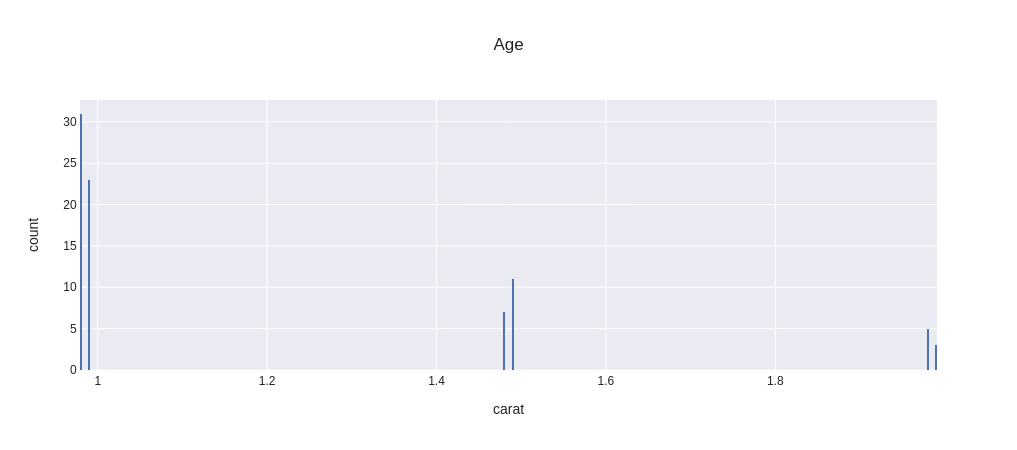

In [114]:
fig=px.histogram(df.loc[df['marketing_carat']=='bad'], x='carat',nbins=1000,template='seaborn',title='Age',barmode='group')
fig.show()

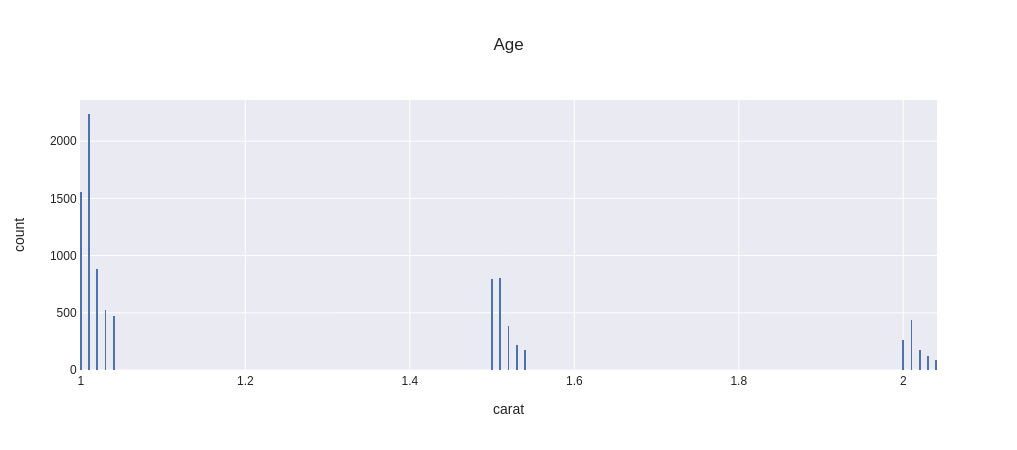

In [116]:
fig=px.histogram(df.loc[df['marketing_carat']=='good'], x='carat',nbins=1000,template='seaborn',title='Age',barmode='group')
fig.show()

In [117]:
df['carat_sqr']=df['carat']**2

# df['carat_sqr'] = np.where(df['carat_sqr']==float('Inf'),0,df['carat_sqr'])

In [118]:
df['high']=''

df.loc[df['carat']<2.26,'high']=1
df.loc[df['carat']>=2.26,'high']=2



df['high'] = df['high'].astype('int64')

In [119]:

# sns.set(font_scale=1)
# dft=df.corr(method='spearman')
# mask = np.triu(np.ones_like(dft, dtype=np.bool))
# f, ax = plt.subplots(figsize=(20, 10))
# cmap = sns.diverging_palette(220, 10, as_cmap=True)
# sns.heatmap(dft, mask=mask, cmap=cmap, vmax=.3, center=0,
#             square=True, linewidths=.5, cbar_kws={"shrink": .5}, annot=True)

# plt.show()

In [120]:
dfd=pd.get_dummies(df)

In [121]:
df.to_parquet('../data/processed/df.parquet')
dfd.to_parquet('../data/processed/dfd.parquet')

In [122]:
df['df_original'].value_counts()

1    40455
0    13485
Name: df_original, dtype: int64

In [123]:
print(df['carat_sqr'].describe())

df[['cut_int','color_int','clarity_int']]

count    53940.000000
mean         0.861390
std          1.056506
min          0.040000
25%          0.160000
50%          0.490000
75%          1.081600
max         25.100100
Name: carat_sqr, dtype: float64


,cut_int,color_int,clarity_int
0,4,1,4
1,3,3,4
2,1,4,5
3,2,7,3
4,5,4,3
...,...,...,...
13480,5,6,3
13481,5,2,4
13482,5,5,5
13483,3,5,2


In [124]:
df.loc[(df['carat']>=2.26)]

,carat,cut,color,clarity,depth,table,price,x,y,z,...,id,cut_int,color_int,clarity_int,cut_color_clarity_score,raw_density,marketing_carat,marketing_carat_int,carat_sqr,high
97,2.30,Ideal,I,SI2,61.8,57.0,16329.0,8.48,8.45,5.23,...,NaN,5,2,2,61.474462,3.682348,regular,2,5.2900,2
283,2.53,Premium,H,SI2,62.6,60.0,14659.0,8.66,8.55,5.39,...,NaN,4,3,2,70.898684,3.803636,regular,2,6.4009,2
501,2.75,Ideal,D,I1,60.9,57.0,13156.0,9.04,8.98,5.49,...,NaN,5,7,1,94.028546,3.702259,regular,2,7.5625,2
665,2.30,Ideal,G,SI2,61.6,57.0,15433.0,8.47,8.41,5.20,...,NaN,5,4,2,81.910196,3.725601,regular,2,5.2900,2
759,2.64,Ideal,H,SI2,62.3,55.0,17407.0,8.88,8.83,5.52,...,NaN,5,3,2,71.692329,3.659674,regular,2,6.9696,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12915,2.52,Fair,H,SI2,65.4,59.0,NaN,8.49,8.42,5.53,...,12915.0,1,3,2,68.517749,3.824784,regular,2,6.3504,2
12972,2.30,Ideal,I,SI2,61.8,57.0,NaN,8.45,8.48,5.23,...,12972.0,5,2,2,61.474462,3.682348,regular,2,5.2900,2
13269,3.00,Fair,H,I1,67.1,57.0,NaN,8.93,8.84,5.97,...,13269.0,1,3,1,49.982498,3.819394,regular,2,9.0000,2
13452,2.34,Very Good,H,I1,62.4,55.4,NaN,8.44,8.51,5.29,...,13452.0,3,3,1,51.569788,3.695213,regular,2,5.4756,2
